In [3]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import scipy.sparse as sp
from MulticoreTSNE import MulticoreTSNE as TSNE

In [4]:
wdir = "/Users/jakobmaeots/Internship/"
os.chdir( wdir )

loom_file = "Data/Velmeshev/Velmeshev_2019_matrix.loom"

# Open the loom file with loompy
ds = lp.connect(loom_file)

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "SCENIC_Output/Velmeshev_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "SCENIC_Output/anndata.h5ad"

# path to pyscenic output
f_pyscenic_output = "SCENIC_Output/velmeshev_pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'SCENIC_Output/velmeshev_scenic_integrated-output.loom'

In [5]:
X = ds[:, :]

# Function to process attributes: try to squeeze to 1D; if not, skip the attribute
def process_attributes(attr_dict):
    new_attrs = {}
    for key in attr_dict.keys():
        try:
            arr = np.array(attr_dict[key])
            arr = np.squeeze(arr)
            if arr.ndim == 1:
                new_attrs[key] = arr
            else:
                print(f"Skipping attribute {key}: array is not 1D after squeezing (shape {arr.shape})")
        except Exception as e:
            print(f"Error processing attribute {key}: {e}")
    return new_attrs

In [6]:
# Process cell attributes (obs) and gene attributes (var)
obs_dict = process_attributes(ds.ca)
var_dict = process_attributes(ds.ra)

# Create DataFrames
obs = pd.DataFrame(obs_dict)
var = pd.DataFrame(var_dict)

# (Optional) If you expect specific keys (like "CellID" or "Gene") use them for index names.
# If these keys are missing or problematic, you can create simple indices.
if "CellID" in ds.ca.keys():
    obs.index = np.array(ds.ca["CellID"]).squeeze()
else:
    obs.index = [f"cell_{i}" for i in range(obs.shape[0])]

if "Gene" in ds.ra.keys():
    var.index = np.array(ds.ra["Gene"]).squeeze()
else:
    var.index = [f"gene_{i}" for i in range(var.shape[0])]

# Loom files are typically genes x cells.
# Scanpy’s AnnData expects the data matrix to be cells x genes.
# Also, if your matrix is large and sparse (which is common), convert it.
if not sp.issparse(X):
    print("Converting expression matrix to sparse CSR format")
    X = sp.csr_matrix(X)

Converting expression matrix to sparse CSR format


In [7]:
adata = sc.AnnData(X=X.T, obs=obs, var=var)
adata.var_names_make_unique()
# Close the loom file connection
ds.close()

# Verify the resulting AnnData object
print(adata)

AnnData object with n_obs × n_vars = 104559 × 65217
    obs: 'CT_ann_ABM_MCA_scmap_cell2cluster_51_CTs', 'CT_ann_score_ABM_MCA_scmap_cell2cluster_51_CTs', 'Capbatch', 'RNA Integrity Number', 'RNA mitochondr. percent', 'RNA ribosomal percent', 'Seqbatch', 'UMIs', 'age', 'batch', 'brain_region', 'cell', 'cell_id', 'cluster', 'condition', 'donor_id', 'genes', 'obs_names', 'post_mortem_interval', 'region', 'sample', 'sex', 'study_id'
    var: 'Gene', 'ensembl_id', 'gene_name', 'var_names'


/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/anndata/utils.py:268: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [8]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_43365/1167869884.py:2: FutureWarning: Use `print_header` instead
  sc.logging.print_versions()


In [9]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

In [10]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  32212542.0
Number of cells in which each gene is detected: 0  -  104067


In [11]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  3136.77
minSamples:  1045.59


In [12]:
# Simply compute the number of genes per cell
sc.pp.filter_cells(adata, min_genes=0)

# Identify mitochondrial genes, assuming gene names starting with 'MT-'
mito_genes = adata.var_names.str.startswith('MT-')

# Compute the sum of counts in mitochondrial genes for each cell
mito_sum = np.array(adata[:, mito_genes].X.sum(axis=1)).flatten()

# Compute the total counts per cell
total_sum = np.array(adata.X.sum(axis=1)).flatten()

# Compute percent mitochondrial and add total counts to adata.obs
adata.obs['percent_mito'] = mito_sum / total_sum
adata.obs['n_counts'] = total_sum

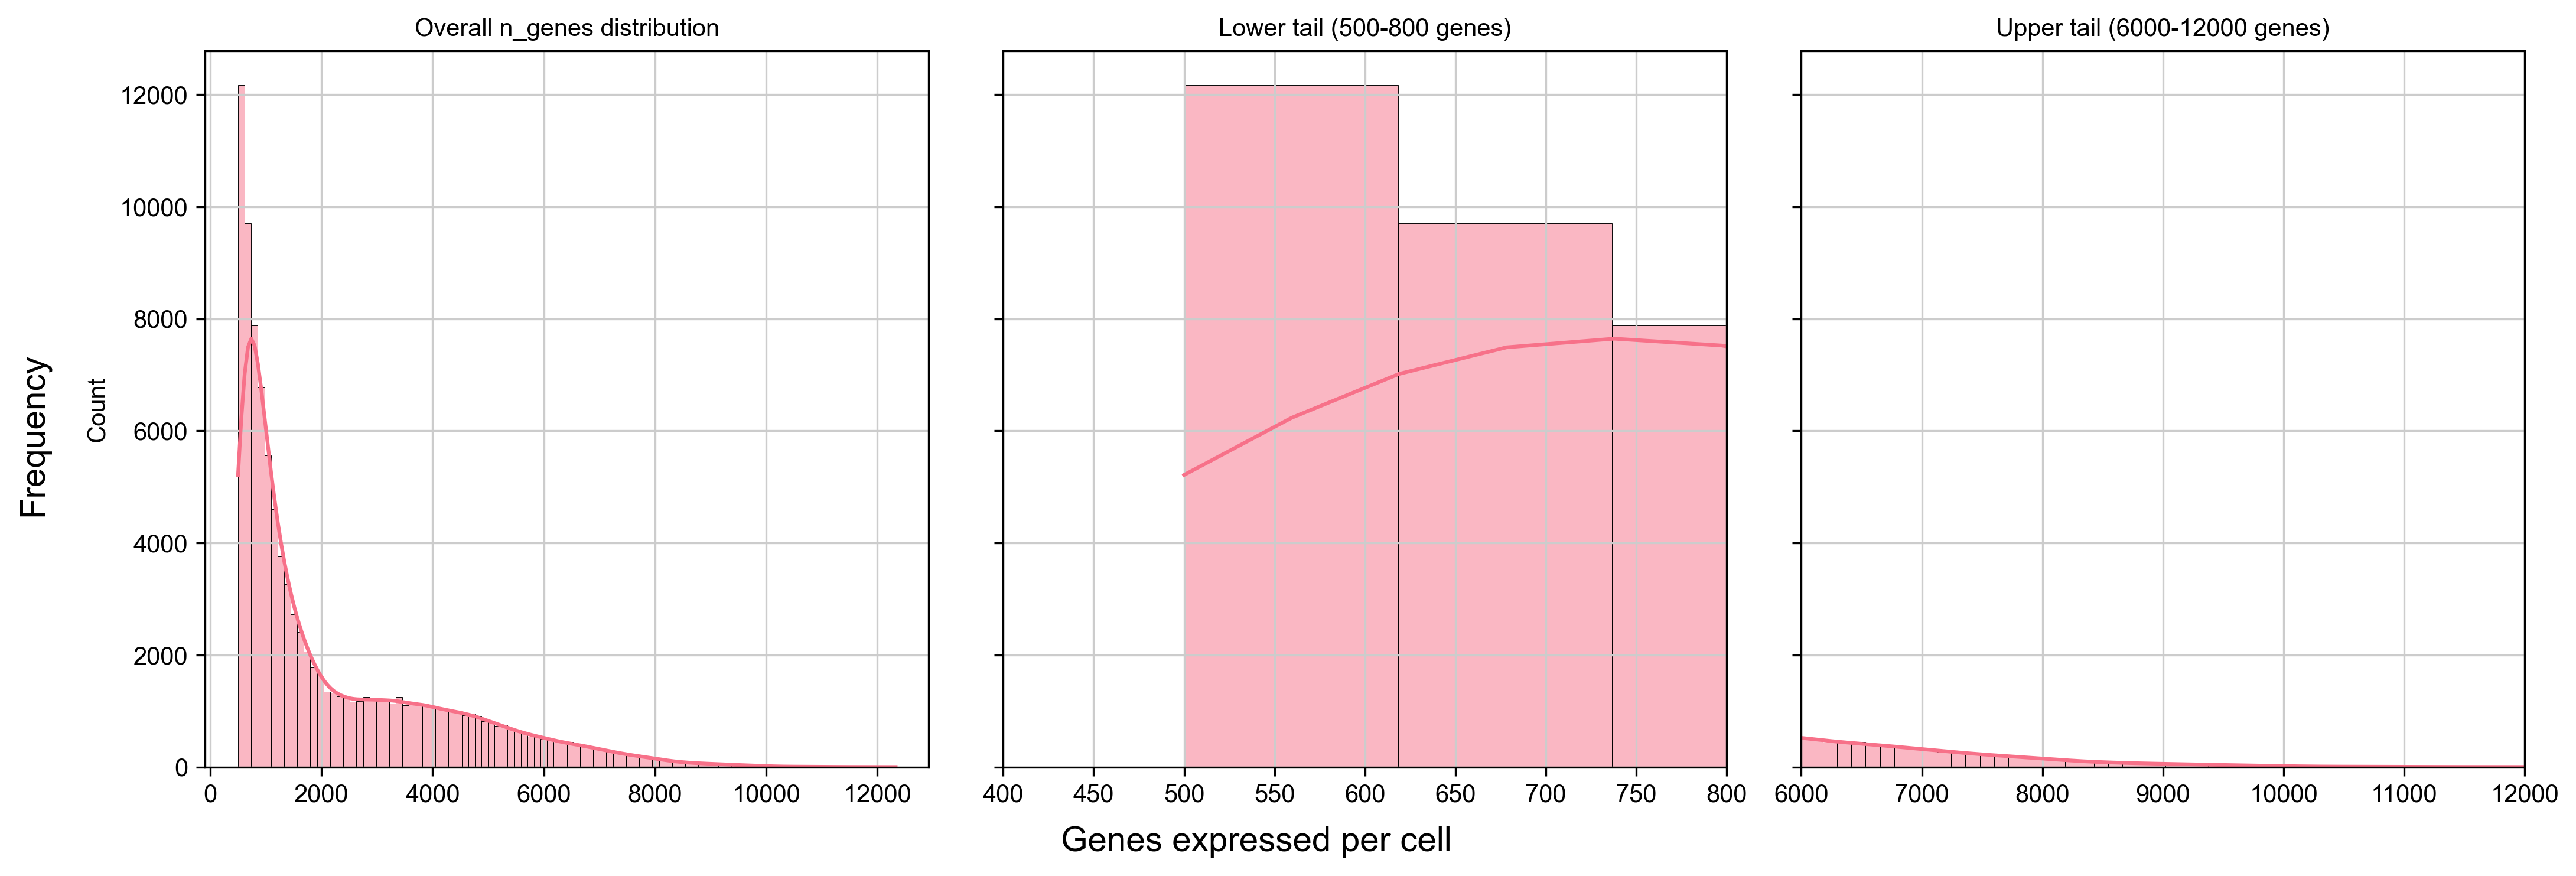

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette
sns.set_palette("husl")

# Use the n_genes column from your AnnData object
x = adata.obs['n_genes']

# Define the number of bins for the histogram
nbins = 100

# Create subplots: overall distribution, lower tail, and upper tail
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=150, sharey=True)

# Overall n_genes distribution
sns.histplot(x, ax=ax1, bins=nbins, kde=True)
ax1.set_title('Overall n_genes distribution')

# Lower tail: limit x-axis from 500 to 800
sns.histplot(x, ax=ax2, bins=nbins, kde=True)
ax2.set_xlim(400, 800)
ax2.set_title('Lower tail (500-800 genes)')

# Upper tail: limit x-axis from 6000 to 12000
sns.histplot(x, ax=ax3, bins=nbins, kde=True)
ax3.set_xlim(6000, 12000)
ax3.set_title('Upper tail (6000-12000 genes)')

# Remove individual x-axis labels (use global x-label instead)
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('')

# Add a common y-axis label for Frequency
fig.text(0.04, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=14)

# Add a common x-axis label for Genes expressed per cell
fig.text(0.5, 0.04, 'Genes expressed per cell', ha='center', va='center', fontsize=14)

# Adjust layout to minimize overlap
fig.tight_layout(rect=[0.05, 0.05, 1, 1])

plt.show()

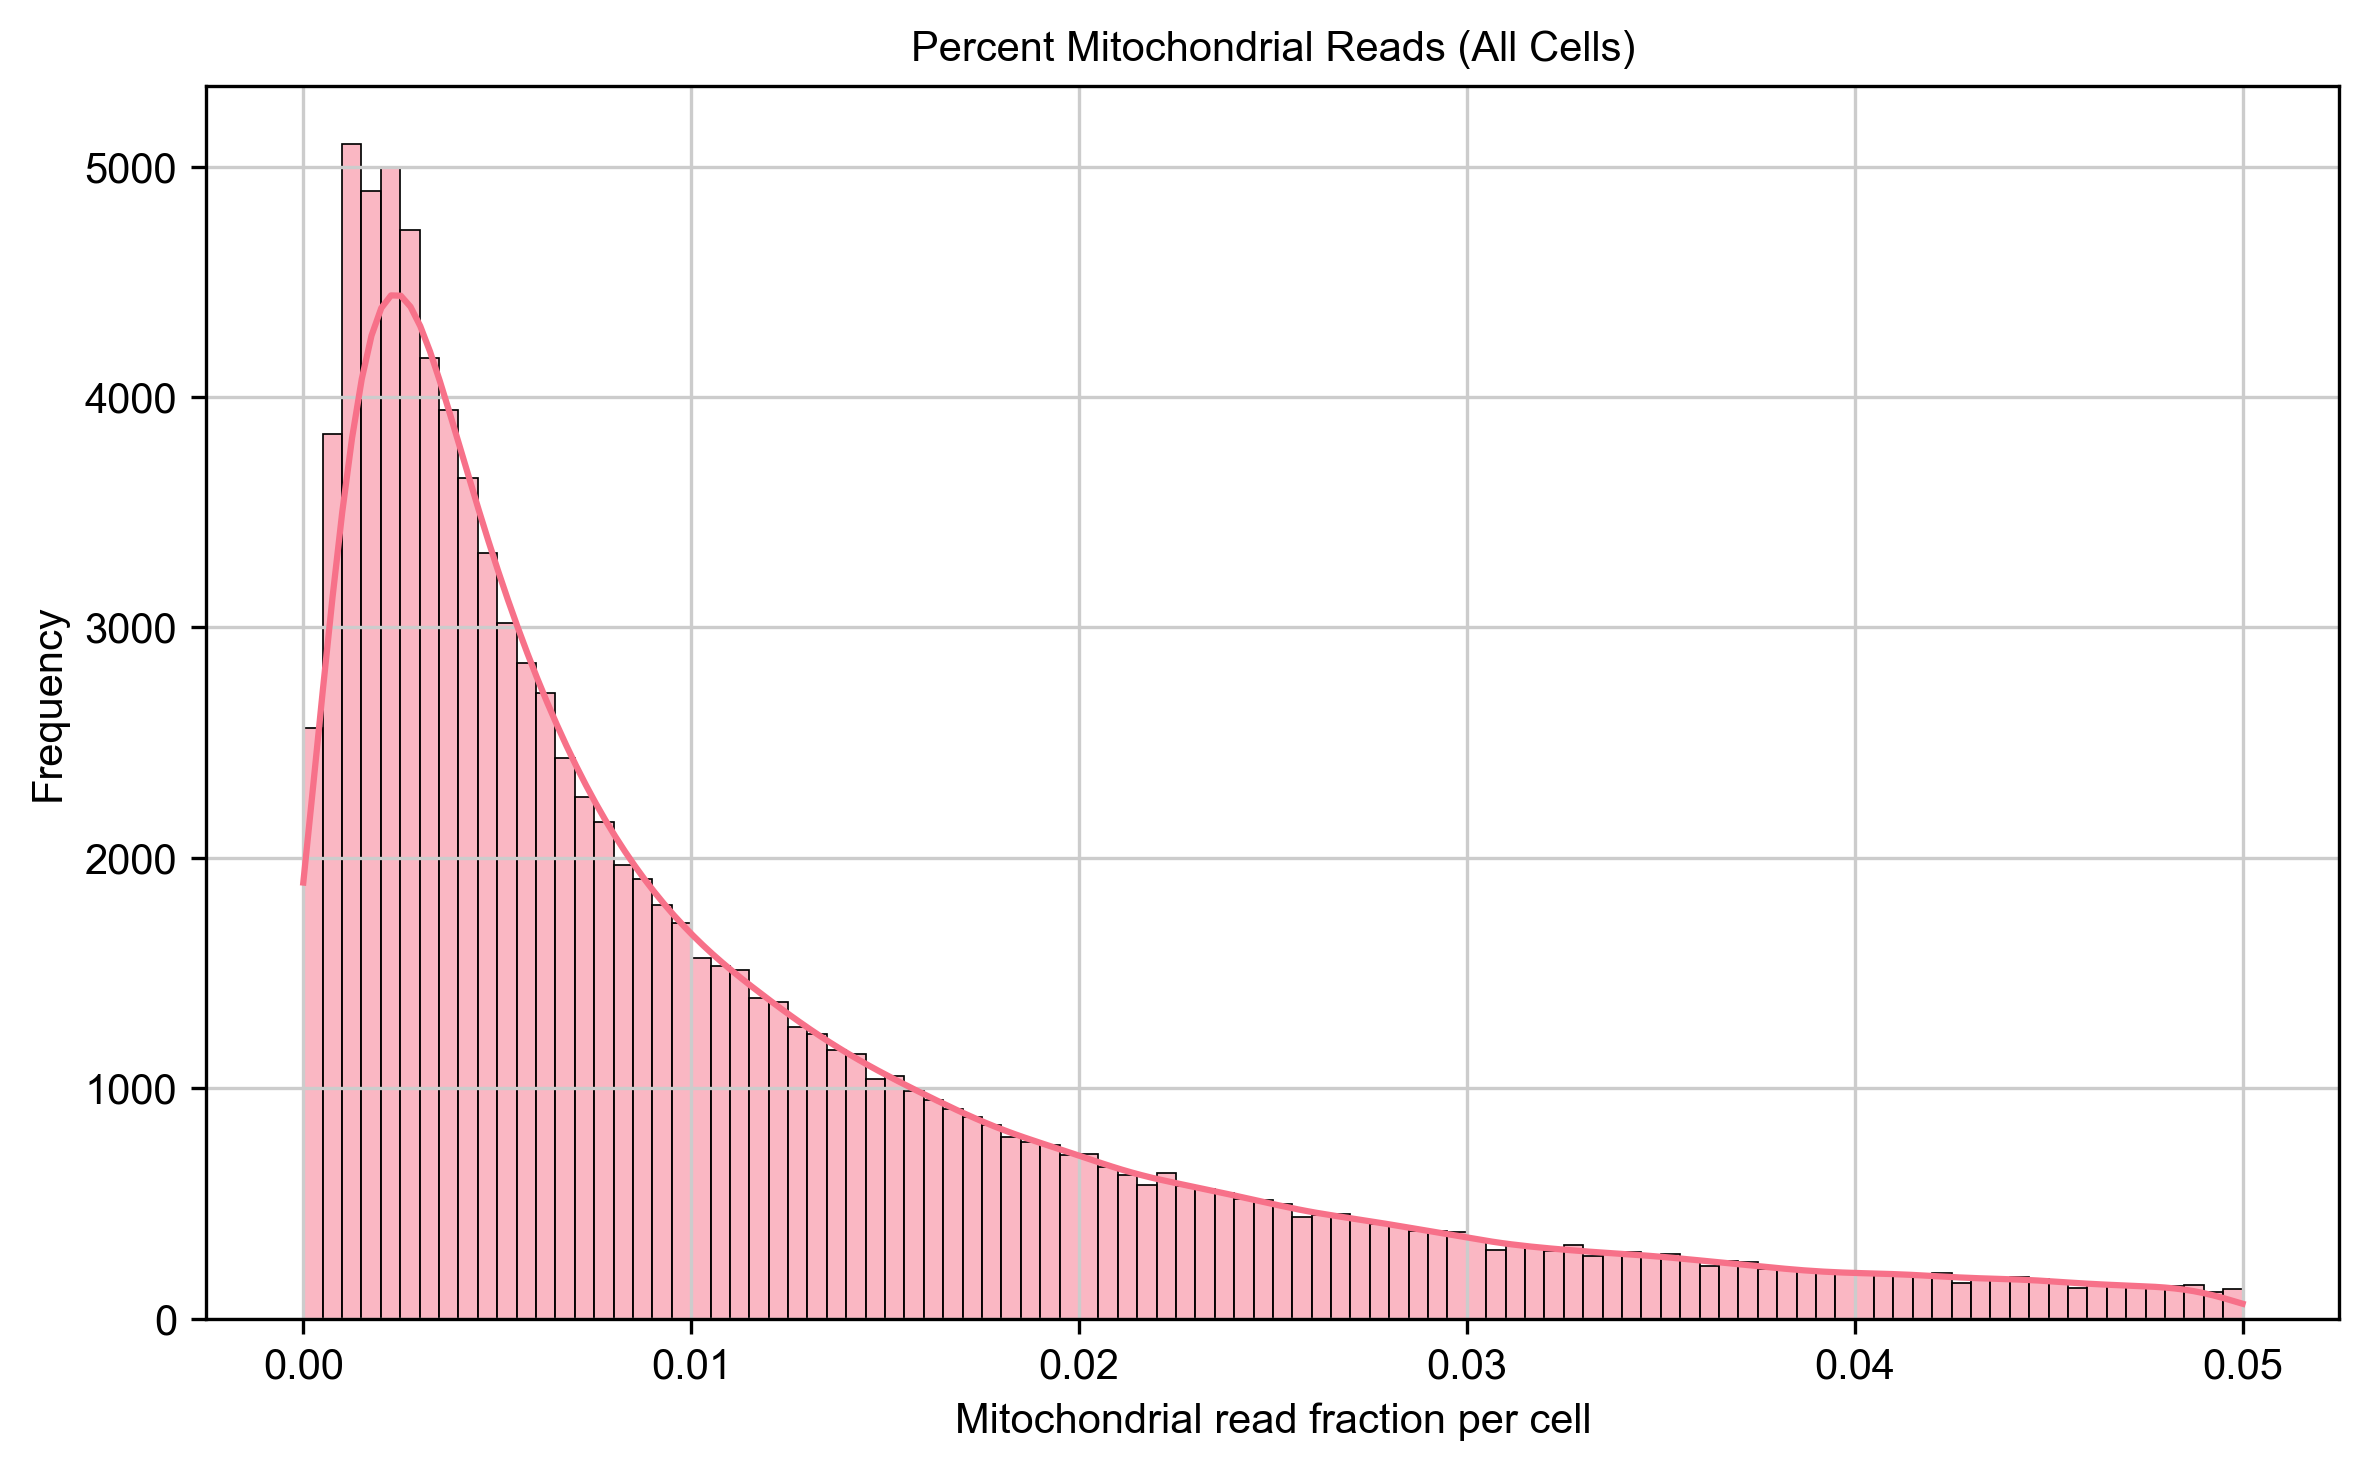

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette (optional)
sns.set_palette("husl")

# Extract your data
x = adata.obs['percent_mito']
nbins = 100

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=150)
sns.histplot(x, ax=ax, bins=nbins, kde=True)
ax.set_title("Percent Mitochondrial Reads (All Cells)")
ax.set_xlabel("Mitochondrial read fraction per cell")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

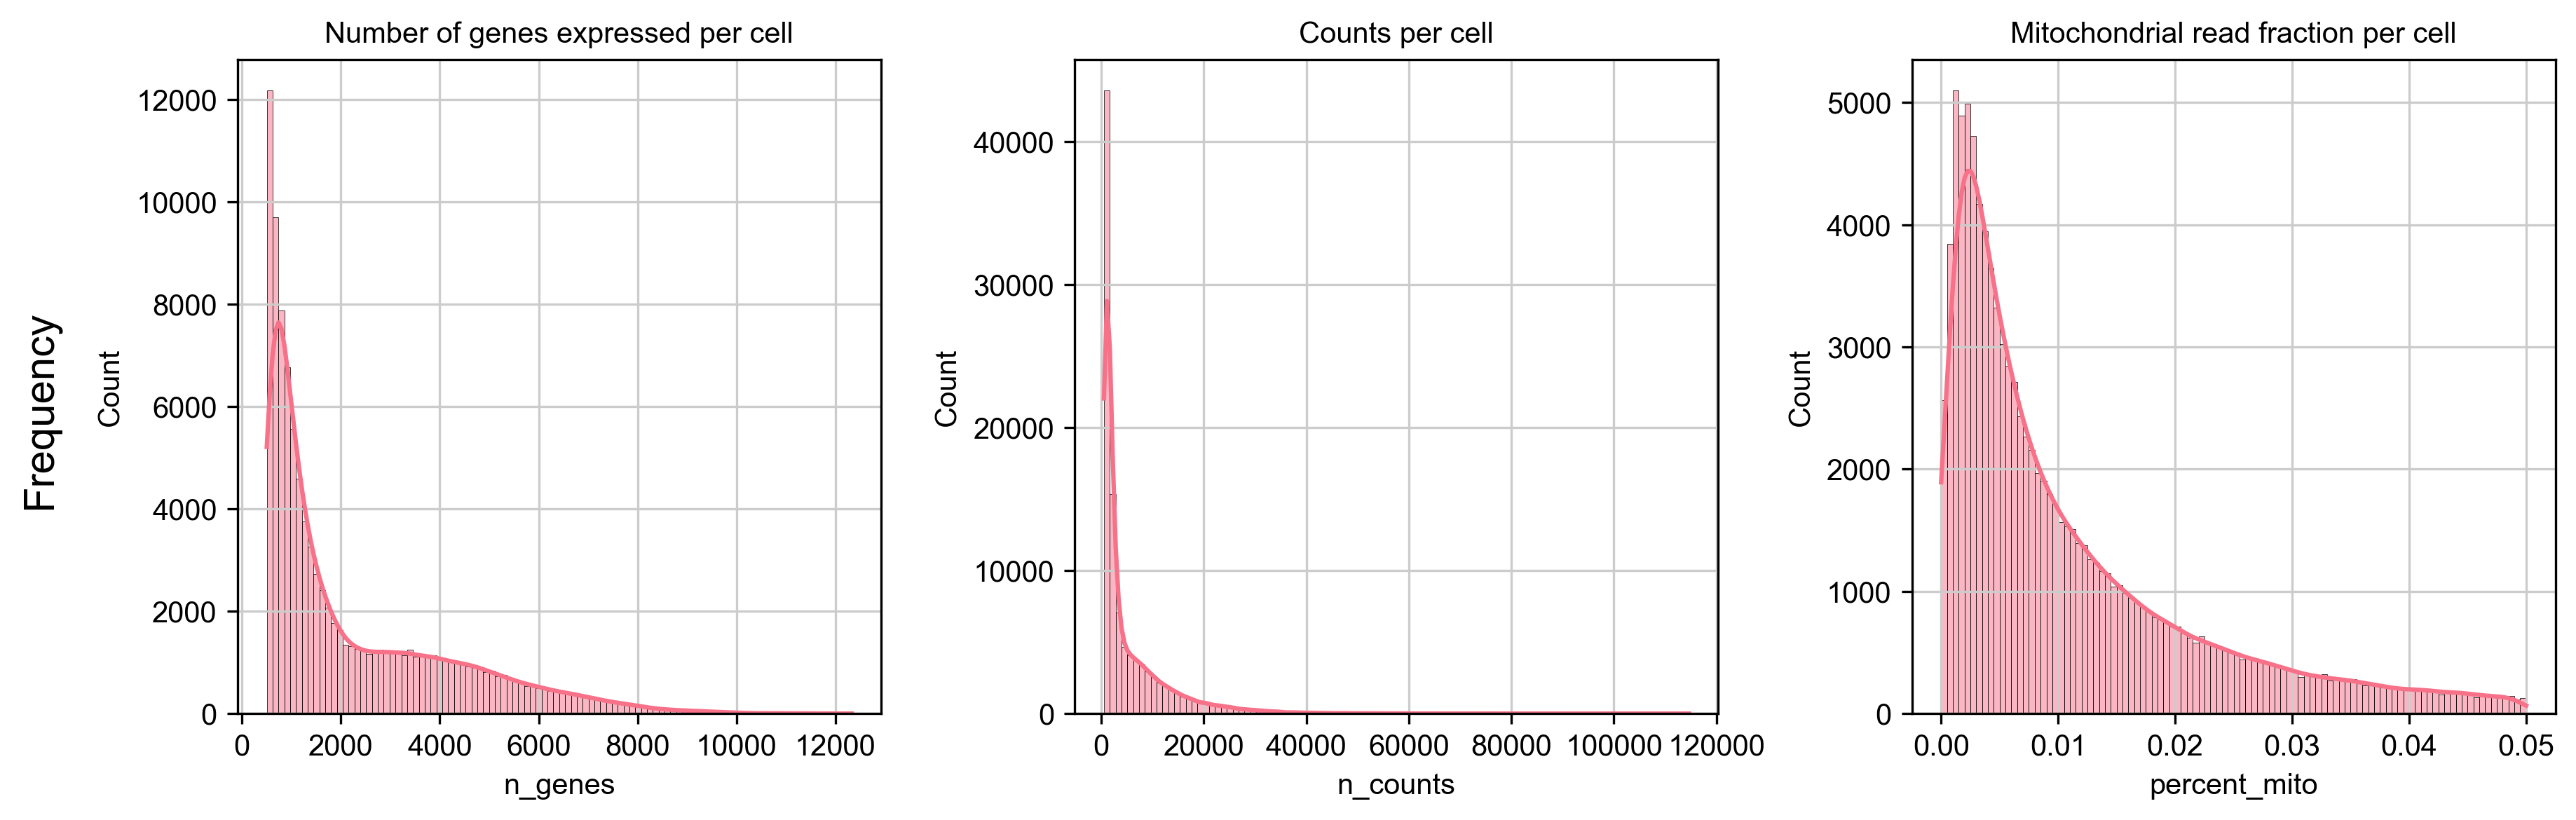

In [15]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

# Plot histograms with kernel density estimates
sns.histplot(adata.obs['n_genes'], ax=ax1, bins=100, kde=True)
sns.histplot(adata.obs['n_counts'], ax=ax2, bins=100, kde=True)
sns.histplot(adata.obs['percent_mito'], ax=ax3, bins=100, kde=True)

# Set titles
ax1.set_title('Number of genes expressed per cell')
ax2.set_title('Counts per cell')
ax3.set_title('Mitochondrial read fraction per cell')

# Set y-axis label
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

# Adjust layout
fig.tight_layout()

# Save the figure
fig.savefig('filtering_panel_prefilter_velmeshev.pdf', dpi=600, bbox_inches='tight')

/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:921: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g: sns.axisgrid.FacetGrid = sns.catplot(


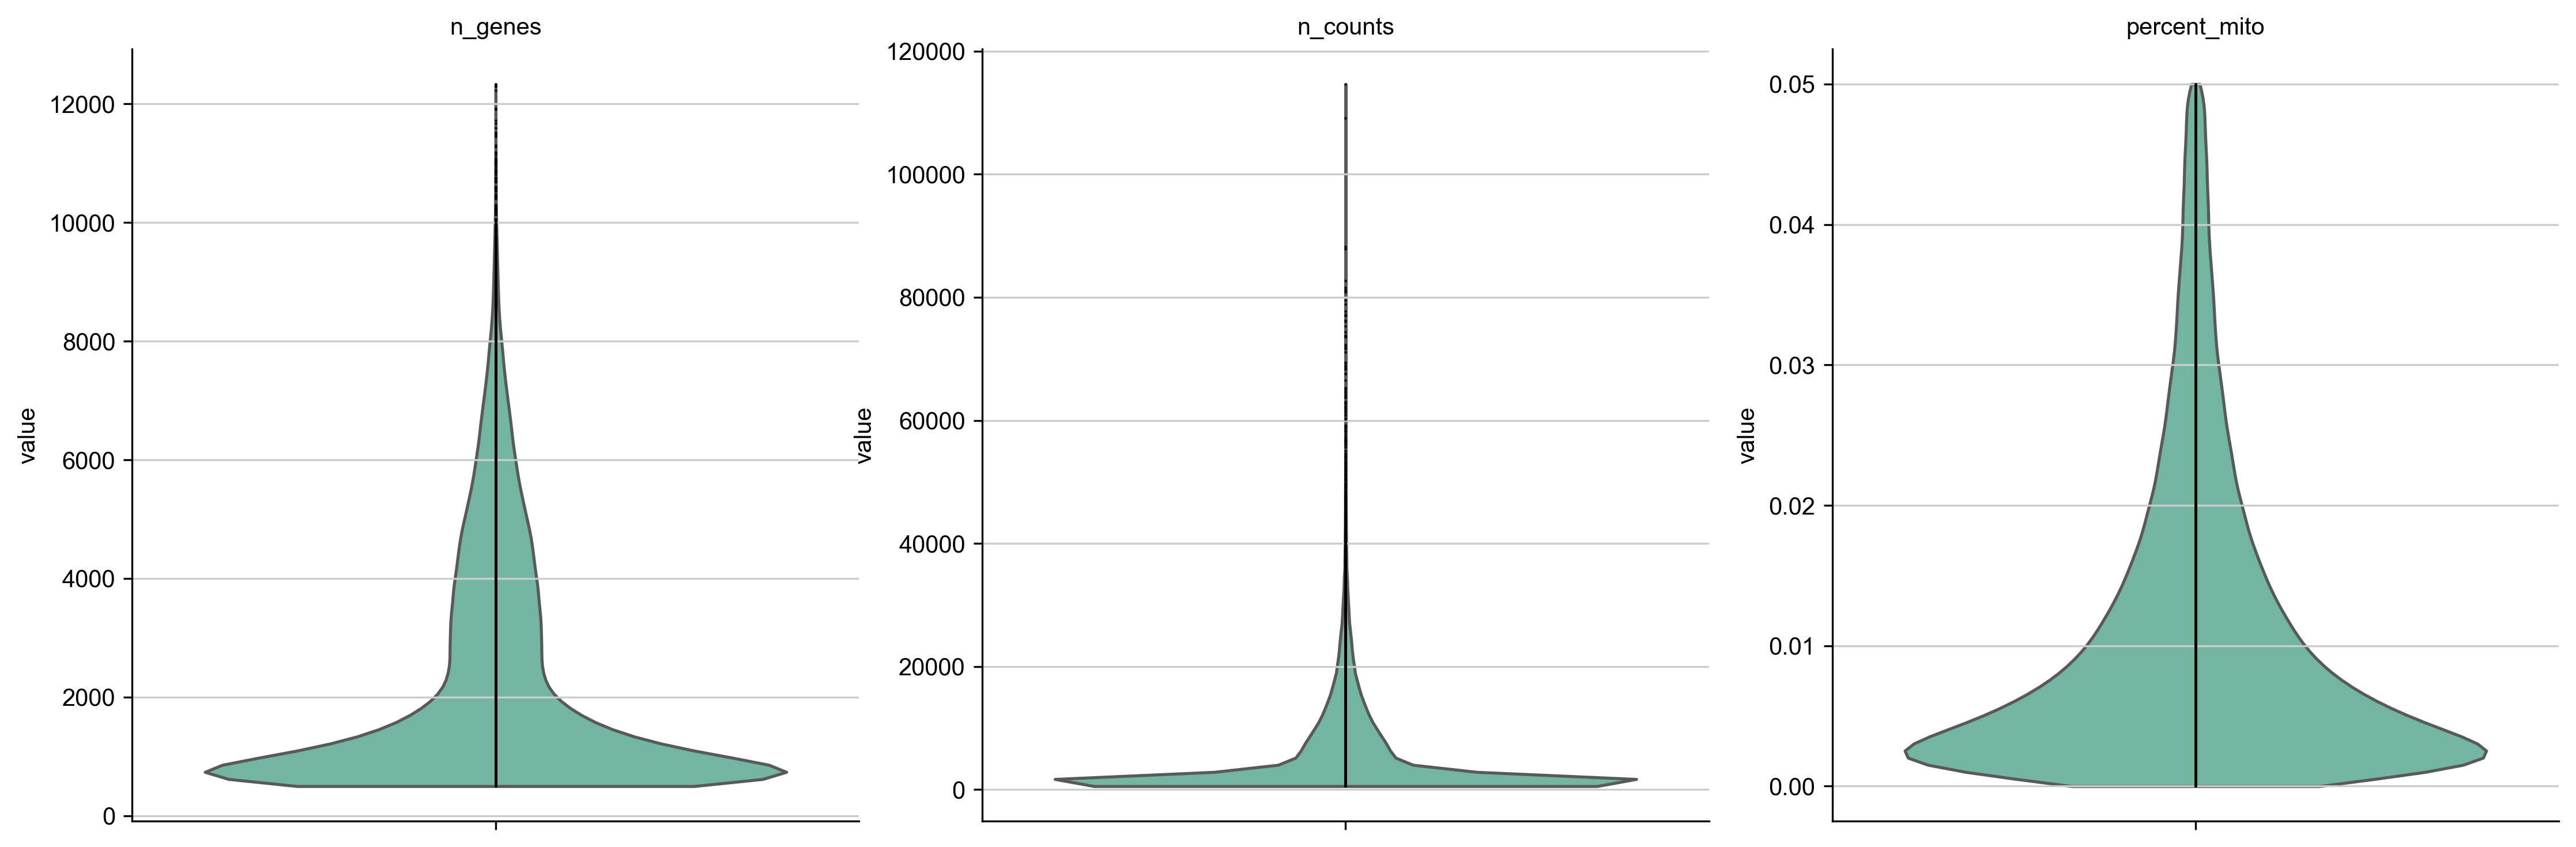

In [16]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0, multi_panel=True, palette="Set2")

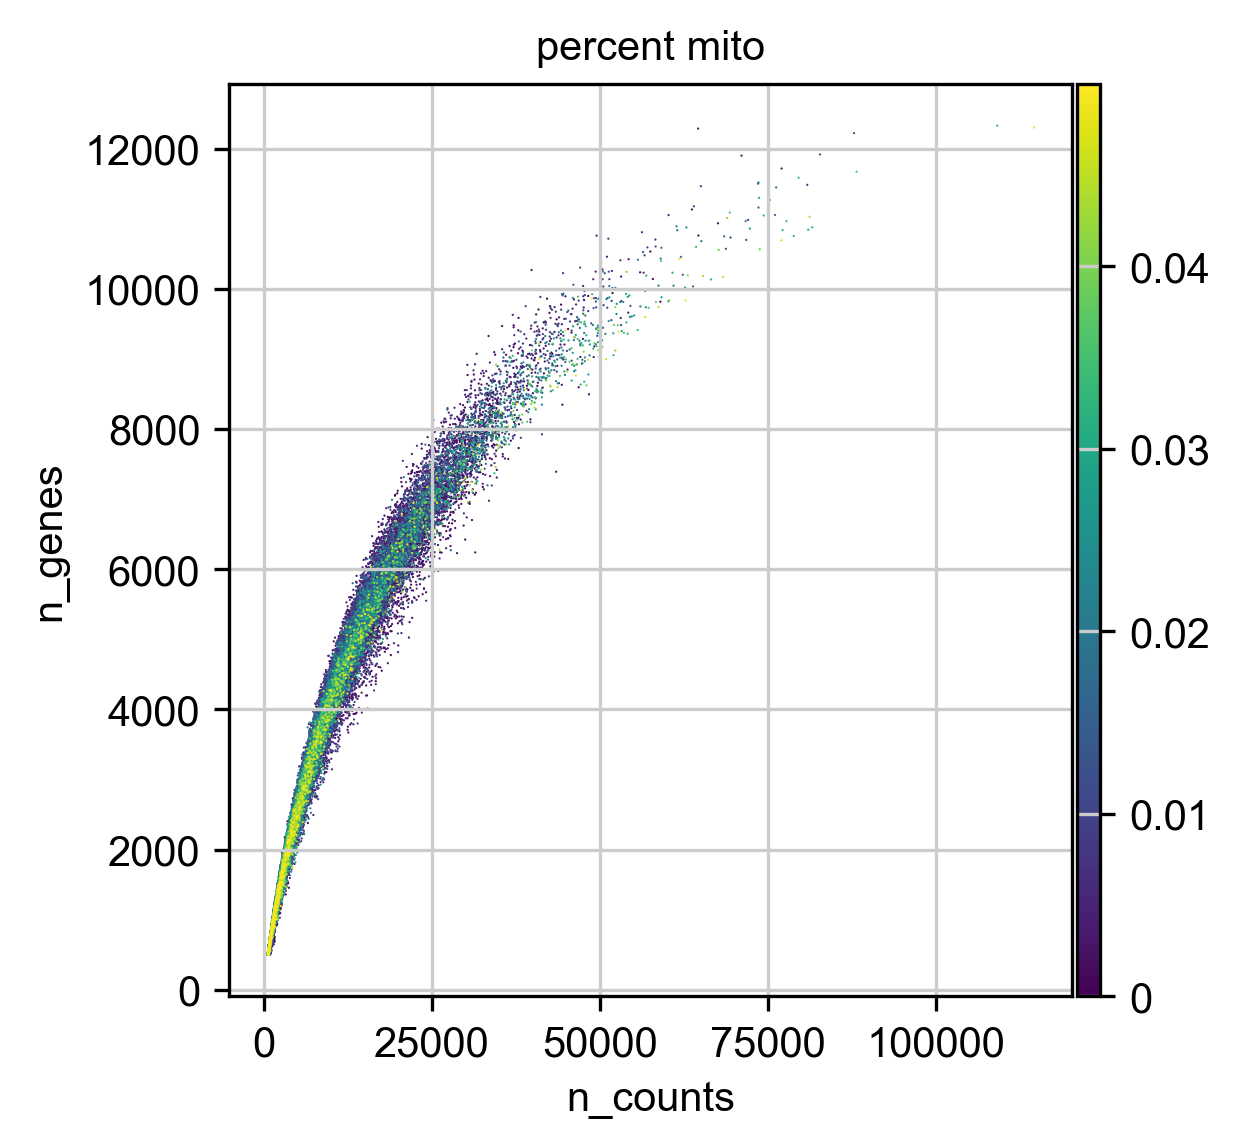

In [17]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [18]:
sc.pp.filter_cells(adata, min_genes=500 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 27254 genes that are detected in less than 3 cells


In [19]:
adata = adata[adata.obs['n_genes'] < 6000, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

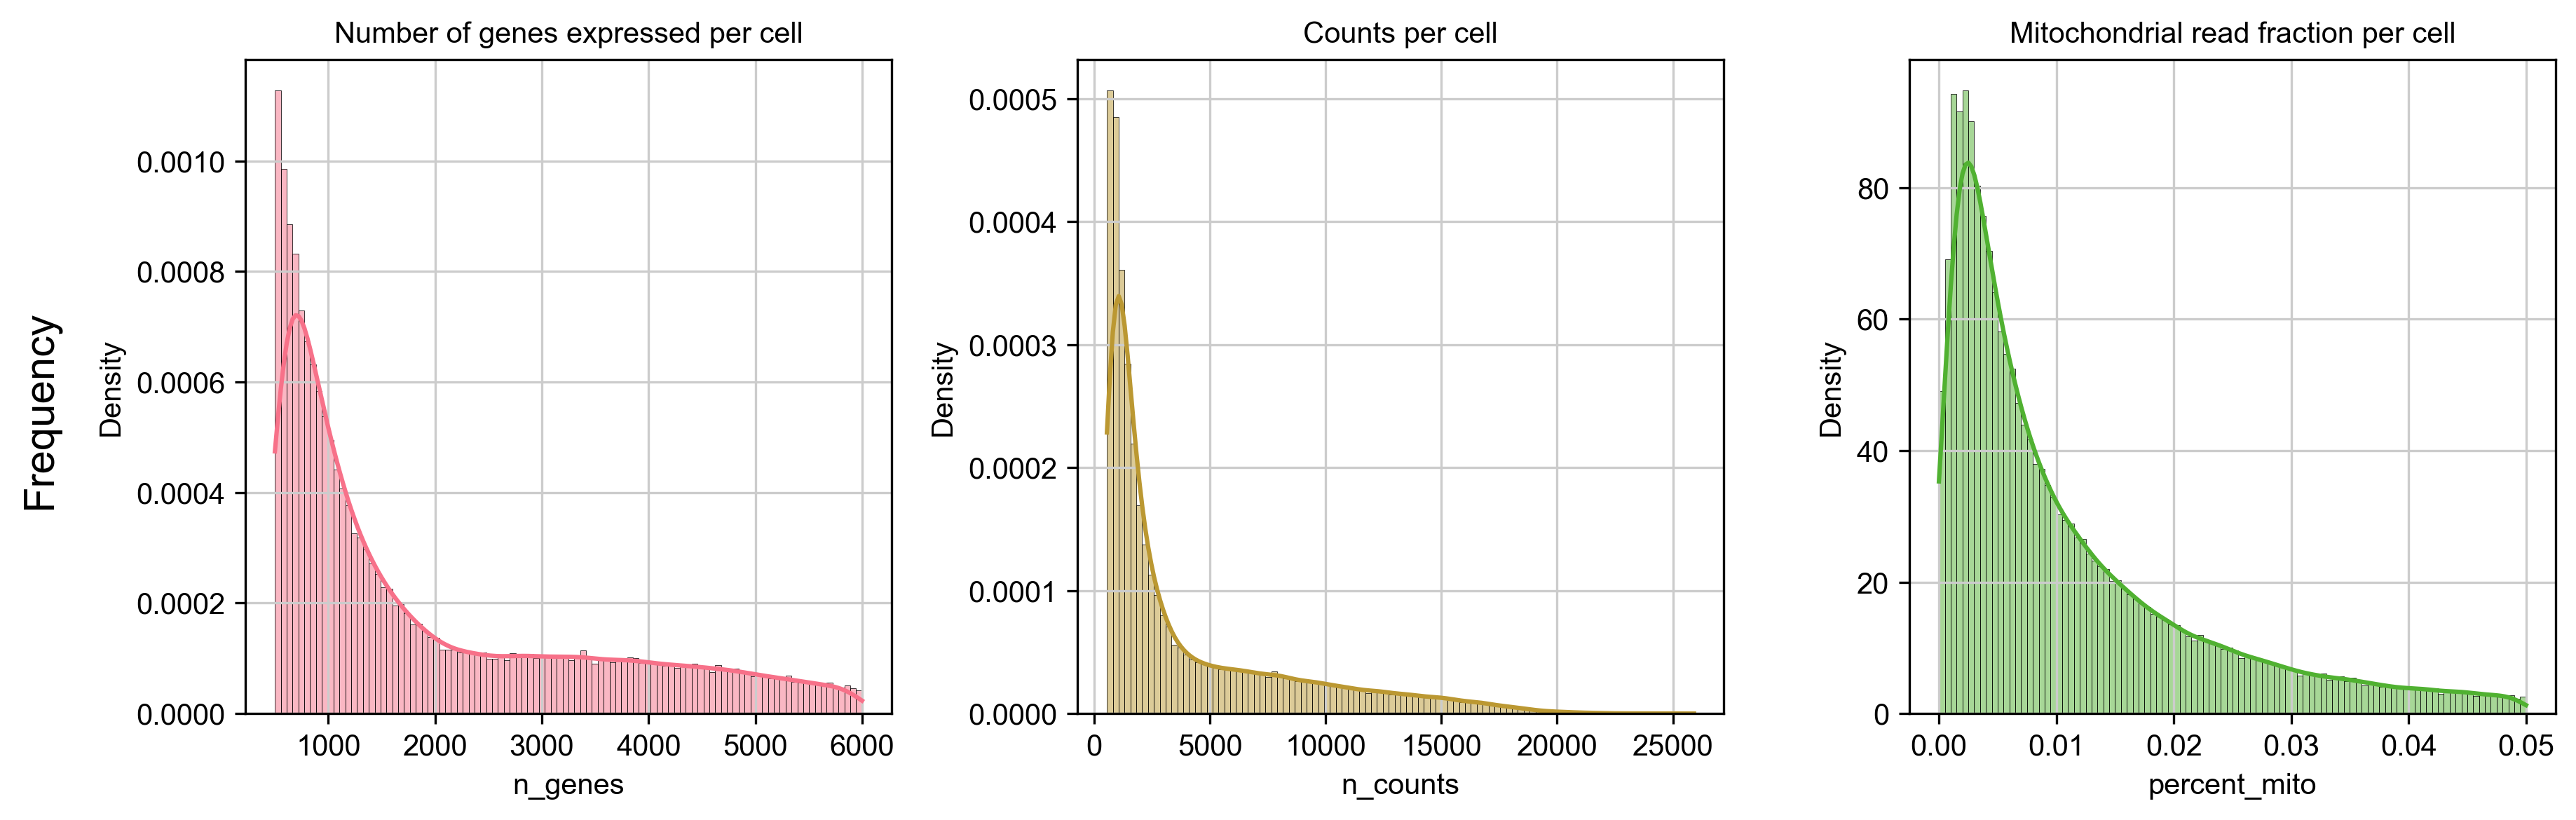

In [20]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

# Plot histograms with kernel density estimates
sns.histplot(adata.obs['n_genes'], ax=ax1, bins=100, kde=True, color=sns.color_palette("husl")[0], stat="density")
sns.histplot(adata.obs['n_counts'], ax=ax2, bins=100, kde=True, color=sns.color_palette("husl")[1], stat="density")
sns.histplot(adata.obs['percent_mito'], ax=ax3, bins=100, kde=True, color=sns.color_palette("husl")[2], stat="density")

# Set titles
ax1.set_title('Number of genes expressed per cell')
ax2.set_title('Counts per cell')
ax3.set_title('Mitochondrial read fraction per cell')

# Set y-axis label
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

# Adjust layout
fig.tight_layout()

# Save the figure
fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

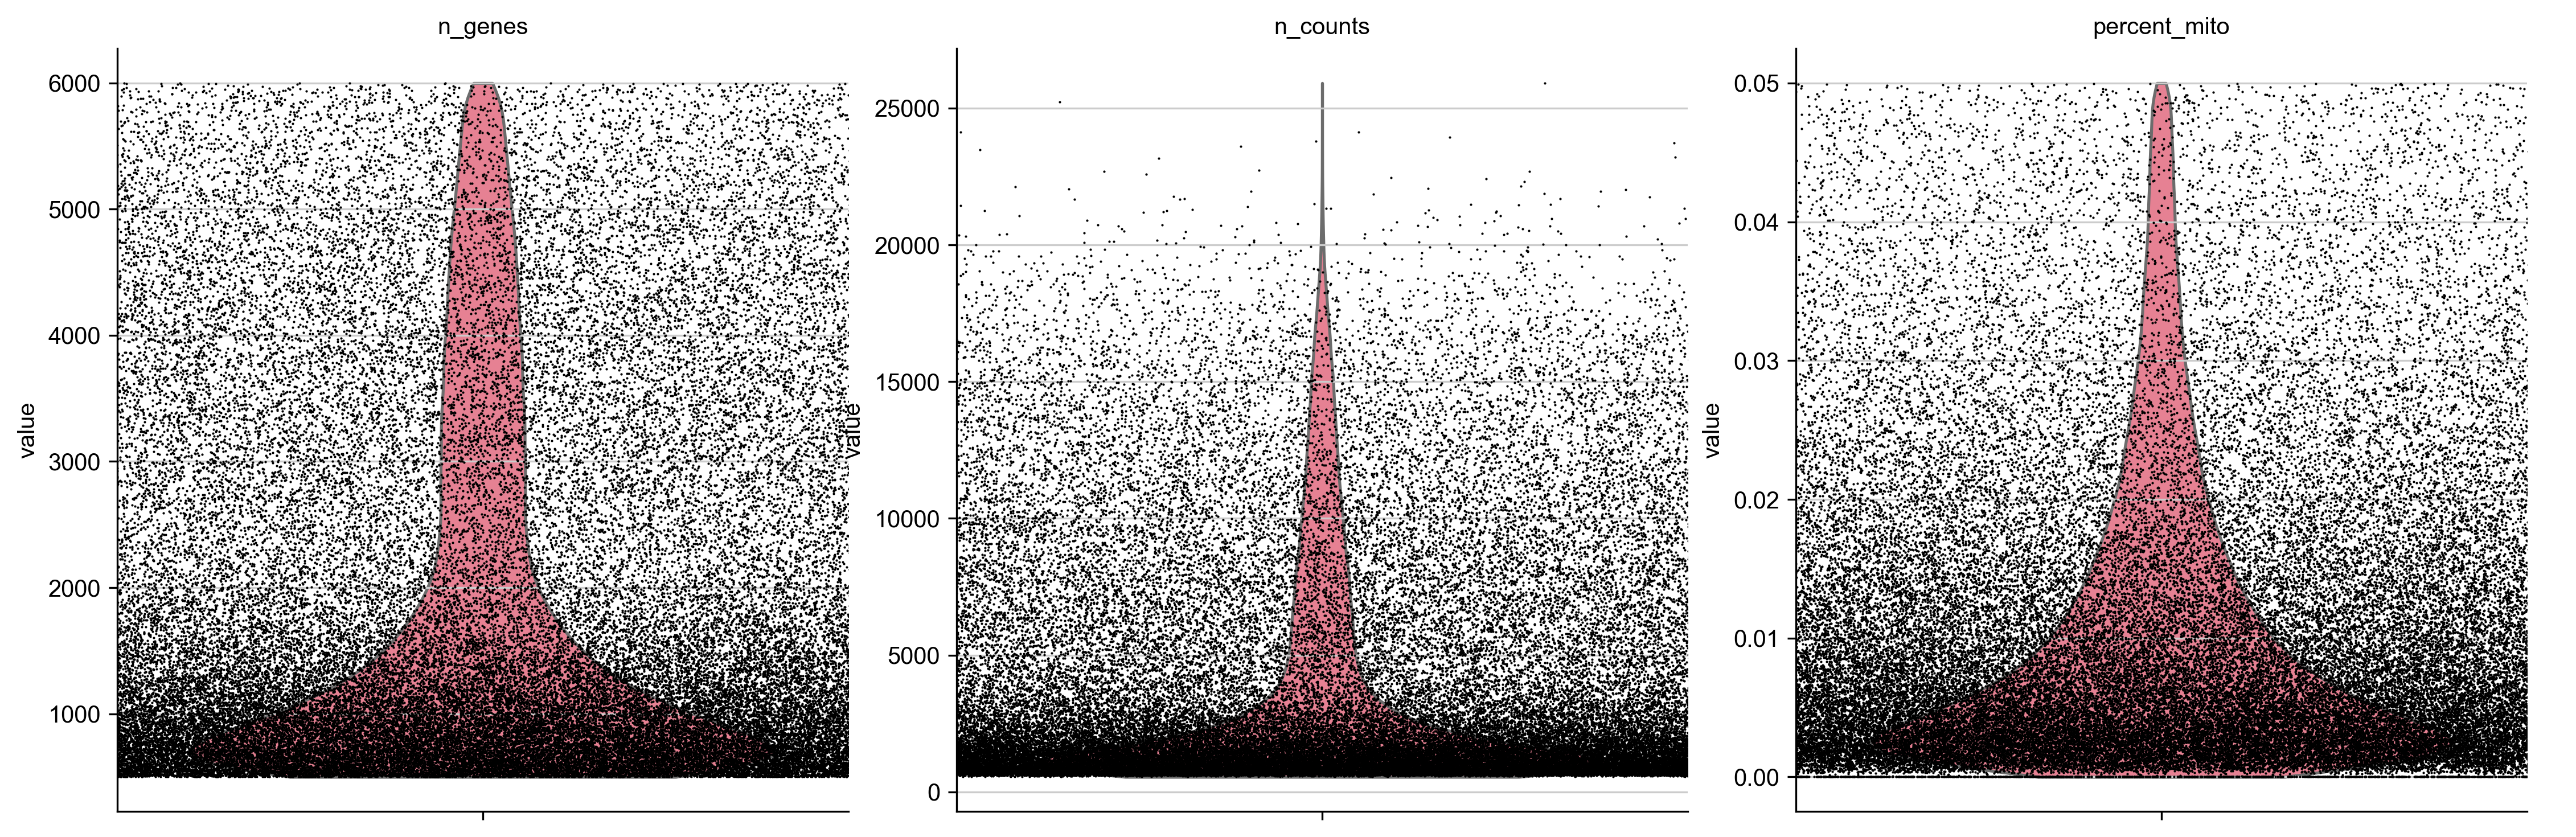

In [21]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.8, multi_panel=True )

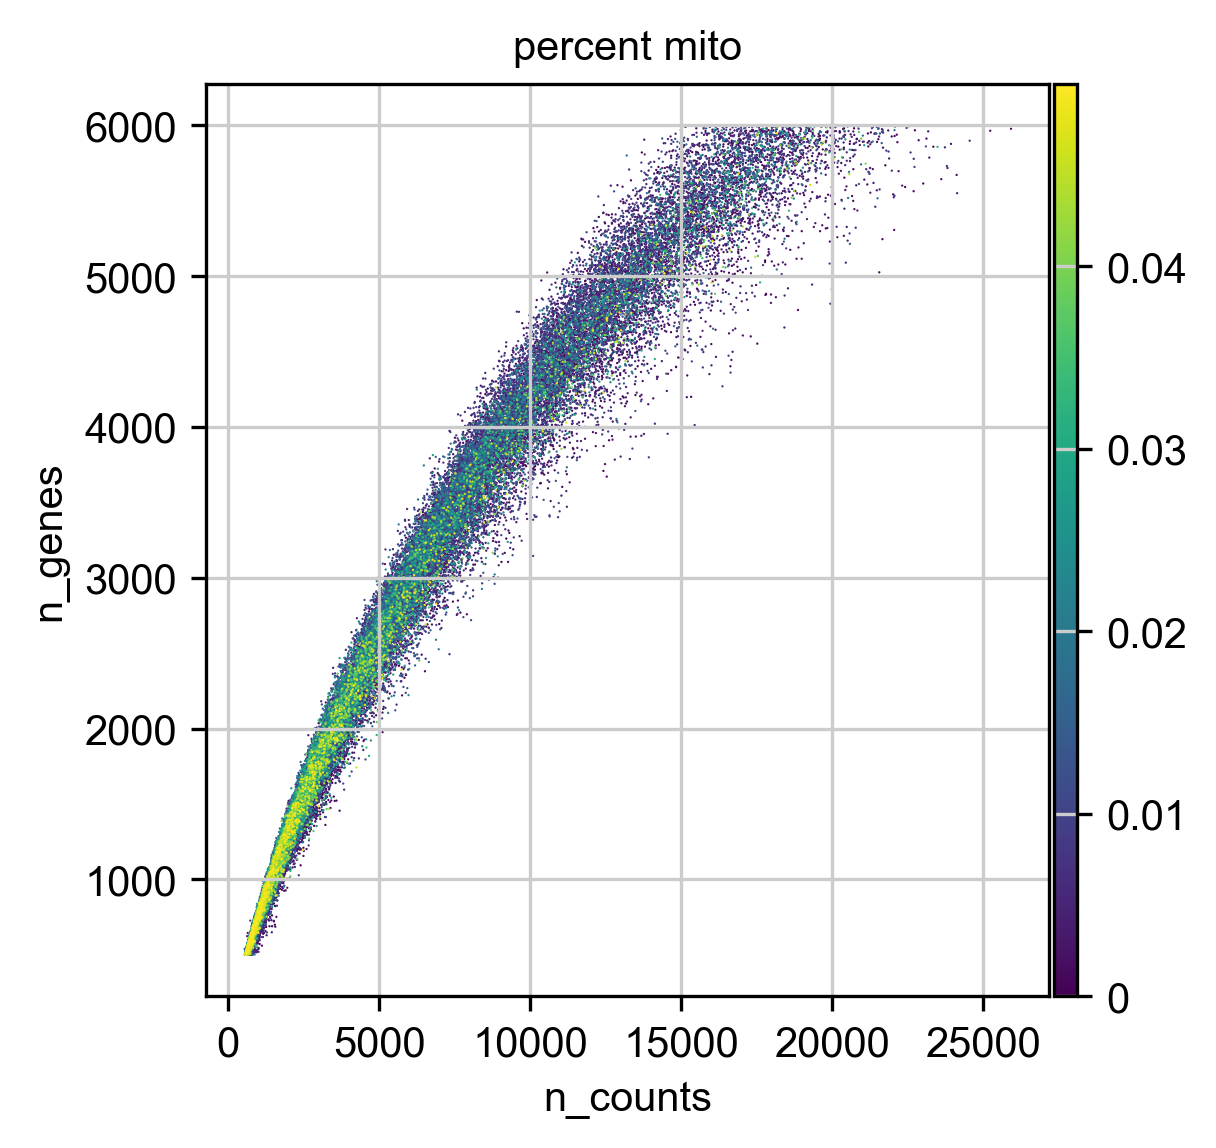

In [22]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [23]:
adata.write( f_anndata_path )

In [24]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

normalizing by total count per cell


/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_43365/3186822170.py:5: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:589: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(


    finished (0:00:05): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


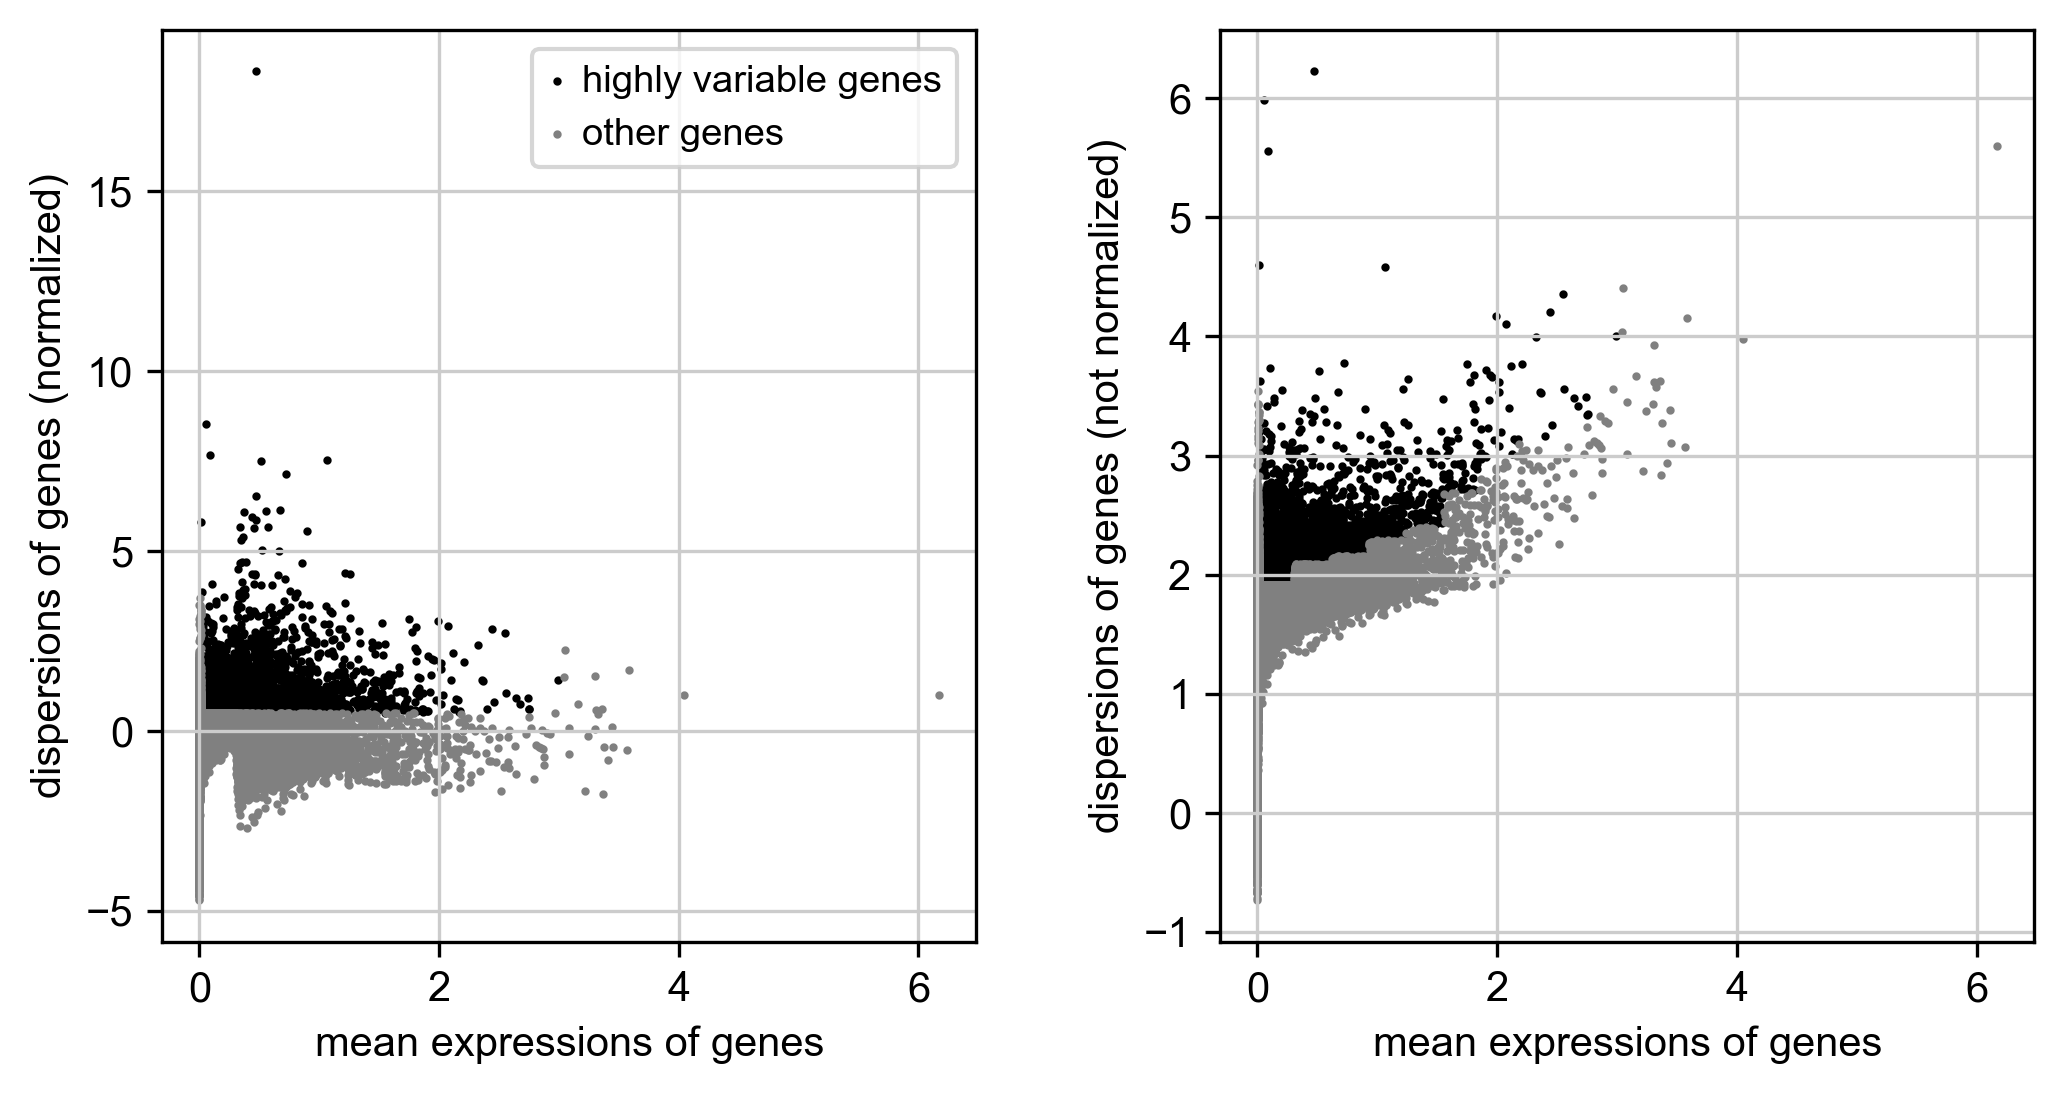

regressing out ['n_counts', 'percent_mito']


/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:710: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    sparse input is densified and may lead to high memory use
    finished (0:01:00)


In [25]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

# update the anndata file:
adata.write( f_anndata_path )

computing PCA
    with n_comps=50
    finished (0:01:04)


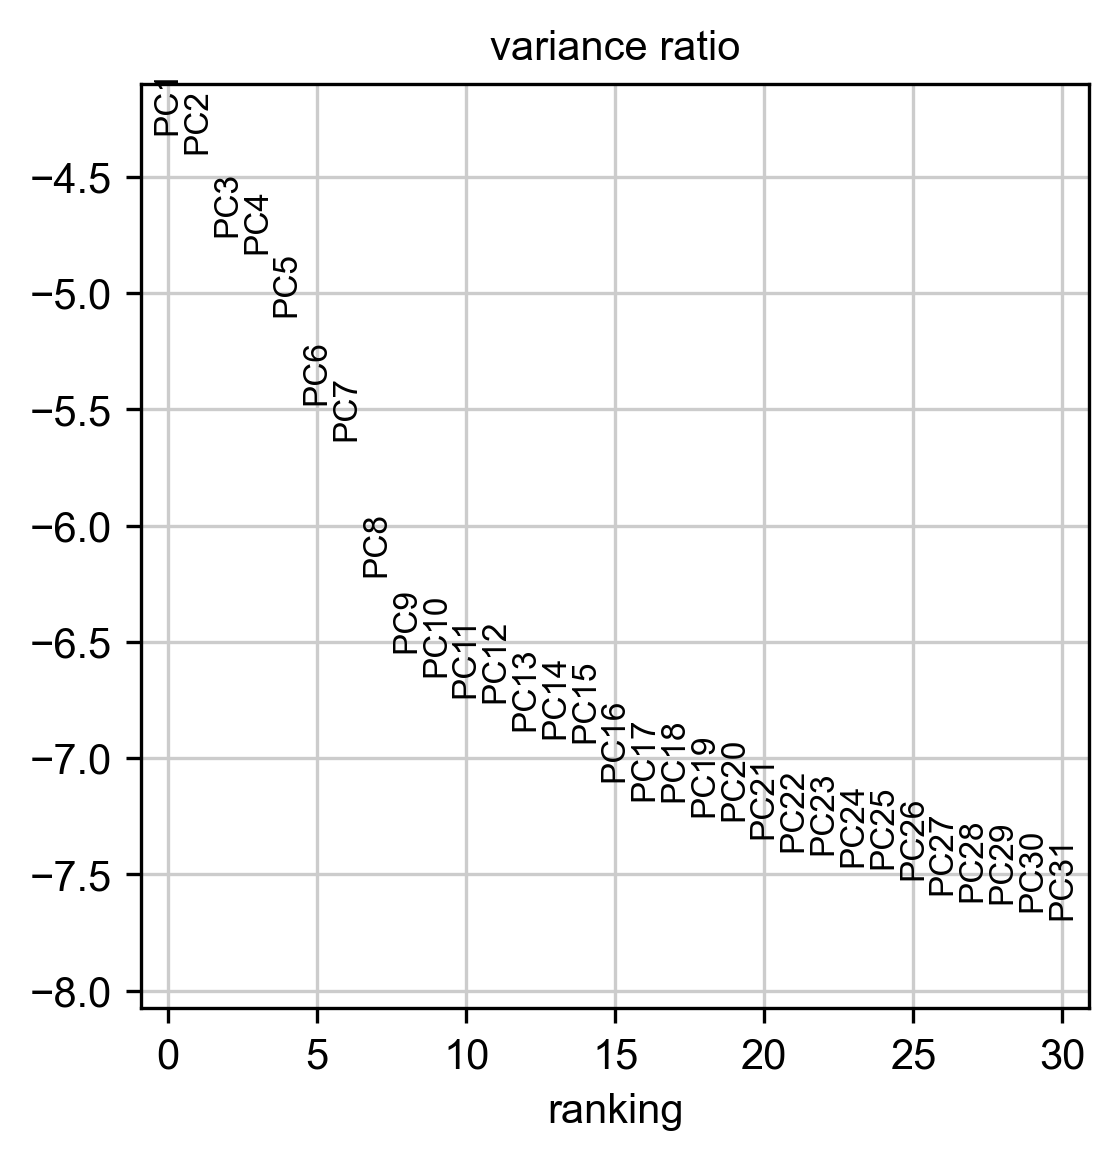

In [26]:
# adata = sc.read_h5ad( f_anndata_path )
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path )

In [ ]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=8)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:44)


In [ ]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.4)

sc.pl.umap(adata, color=['louvain'] )

In [ ]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path )